### Highest Accuracy Model So Far

Submission: 6.3

Train Accuracy: 79.645 % 

Test Accuracy: 76.186 % 

In [1]:
import pandas as pd
import numpy as np
import patsy

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from itertools import combinations
from random import shuffle

In [2]:
# Train X and y
train_X = pd.read_csv('train_X.csv')
train_y = pd.read_csv('train_y.csv')
train = train_X.merge(train_y, on='ID').drop(columns=['ID'])

# Test X
test_X = pd.read_csv('public_private_X.csv')

In [3]:
### ------------------- DATA CLEANING -------------------


### Dealing with datetime columns

# Converting columns containing dates to pd.datetime format (both train and test data)
train['PURCHASE_ORDER_DUE_DATE'] = pd.to_datetime(train['PURCHASE_ORDER_DUE_DATE'])
train['ORDER_DATE'] = pd.to_datetime(train['ORDER_DATE'])

test_X['PURCHASE_ORDER_DUE_DATE'] = pd.to_datetime(test_X['PURCHASE_ORDER_DUE_DATE'])
test_X['ORDER_DATE'] = pd.to_datetime(test_X['ORDER_DATE'])

# Extracting the month and day for these new datetime columns (both train and test data)
train['PURCHASE_ORDER_DUE_DATE_month'] = train['PURCHASE_ORDER_DUE_DATE'].dt.month
train['PURCHASE_ORDER_DUE_DATE_day'] = train['PURCHASE_ORDER_DUE_DATE'].dt.day
train['ORDER_DATE_month'] = train['ORDER_DATE'].dt.month
train['ORDER_DATE_day'] = train['ORDER_DATE'].dt.day

test_X['PURCHASE_ORDER_DUE_DATE_month'] = test_X['PURCHASE_ORDER_DUE_DATE'].dt.month
test_X['PURCHASE_ORDER_DUE_DATE_day'] = test_X['PURCHASE_ORDER_DUE_DATE'].dt.day
test_X['ORDER_DATE_month'] = test_X['ORDER_DATE'].dt.month
test_X['ORDER_DATE_day'] = test_X['ORDER_DATE'].dt.day

# Dropping the original datetime columns (both train and test data)
train = train.drop(columns=['PURCHASE_ORDER_DUE_DATE', 'ORDER_DATE'])
test_X = test_X.drop(columns=['PURCHASE_ORDER_DUE_DATE', 'ORDER_DATE'])


### Dealing with columns that only have one unique value

# Getting the columns with only one unique value, then dropping them
train.drop(columns=train.columns[train.nunique() == 1], inplace=True)


### Defining numerical and categorical columns

cat_preds = [
    'DIVISION_NUMBER',
    'ORDER_DAY_OF_WEEK',
    'PURCHASE_ORDER_TYPE',
    'DIVISION_CODE',
    'DUE_DATE_WEEKDAY',
    'PRODUCT_CLASSIFICATION',
    'COMPANY_VENDOR_NUMBER', # IMMENSELY IMPORTANT --> talk about this in the report
    'PURCHASE_FROM_VENDOR',
    #'PRODUCT_NUMBER',
    #'PURCHASE_ORDER_DUE_DATE_month',
    #'ORDER_DATE_month',
    #'PRODUCT_CLASSIFICATION',
]

num_preds = [col for col in train.columns if col not in cat_preds + ["ON_TIME_AND_COMPLETE"]]

In [4]:
### ------------------- MISSING DATA IMPUTATION -------------------
# Detecting the columns with missing values
columns_missingness = train.isna().sum()[train.isna().sum() != 0].index
corr_matrix = train[num_preds].corr().abs()
# For the columns with missing values, finding which column it has the best correlation with, and building a linear regression to impute the missing values
for col in columns_missingness:
    vars_with_highest_corr = list(corr_matrix[col].drop(columns_missingness).sort_values(ascending=False).index[0:5]) # getting the five variables with the highest correlation as X in the LR
    # Building a linear regression to impute col using var_with_highest_corr
    x = train[vars_with_highest_corr]
    y = train[col]
    idx_non_missing = np.isfinite(x).all(axis=1) & np.isfinite(y)
    model = LinearRegression()
    model.fit(x[idx_non_missing], y[idx_non_missing])

    # Imputing the train data
    missing_idx_train = train[col].isna()
    train.loc[missing_idx_train, col] = model.predict(train.loc[missing_idx_train, vars_with_highest_corr])

    # Imputing the test data
    missing_idx_test = test_X[col].isna()
    test_X.loc[missing_idx_test, col] = model.predict(test_X.loc[missing_idx_test, vars_with_highest_corr])



In [5]:
### -------------------- CUSTOM CLASSES FOR PIPELINES --------------------

class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, target_column=None, method='iqr', iqr_multiplier=1.5, strategy='clip'):
        self.columns = columns
        self.target_column = target_column
        self.method = method
        self.iqr_multiplier = iqr_multiplier
        self.strategy = strategy
        self.bounds_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X)

        # Exclude the response variable from feature selection
        if self.target_column and self.target_column in X.columns:
            X_features = X.drop(columns=[self.target_column])
        else:
            X_features = X

        # Use all numerical columns if none are specified
        if self.columns is None:
            self.columns = X_features.select_dtypes(include=np.number).columns.tolist()

        self.bounds_ = {}
        for col in self.columns:
            Q1 = X_features[col].quantile(0.25)
            Q3 = X_features[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - self.iqr_multiplier * IQR
            upper_bound = Q3 + self.iqr_multiplier * IQR
            self.bounds_[col] = (lower_bound, upper_bound)

        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()

        # Apply outlier handling only to selected feature columns
        for col in self.columns:
            lower_bound, upper_bound = self.bounds_[col]

            if self.strategy == 'median':
                median_value = X[col].median()
                X[col] = np.where((X[col] < lower_bound) | (X[col] > upper_bound), median_value, X[col])

            elif self.strategy == 'mean':
                mean_value = X[col].mean()
                X[col] = np.where((X[col] < lower_bound) | (X[col] > upper_bound), mean_value, X[col])

            elif self.strategy == 'clip':
                X[col] = X[col].clip(lower=lower_bound, upper=upper_bound)

        return X


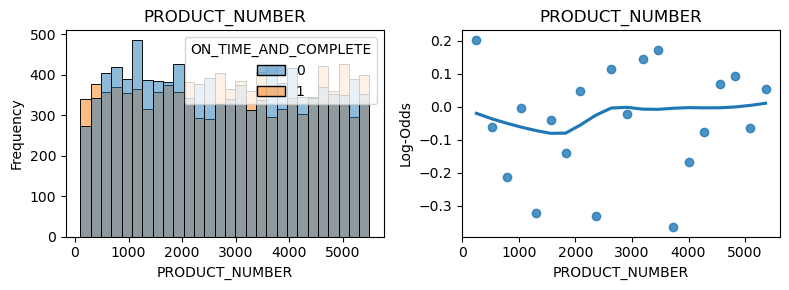

/Users/hayden/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


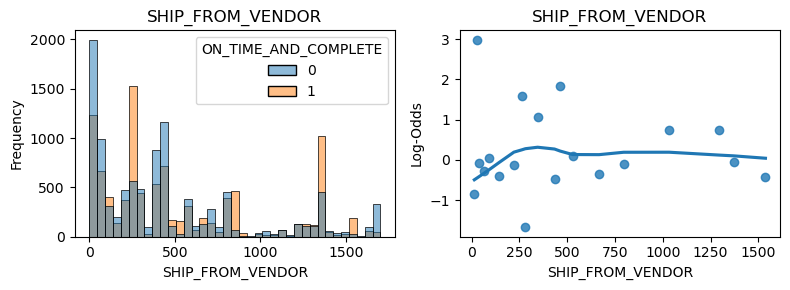

/Users/hayden/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


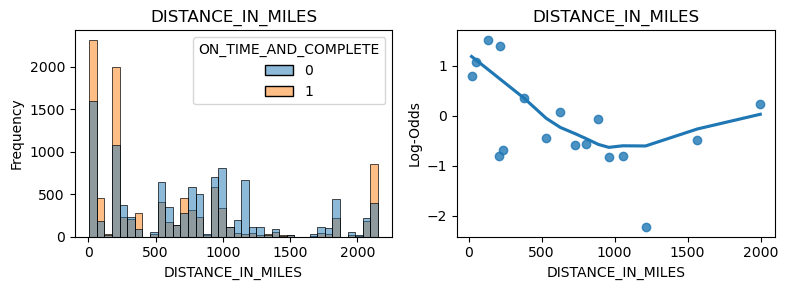

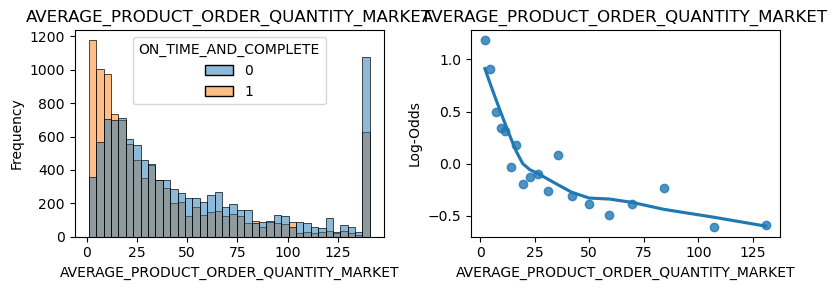

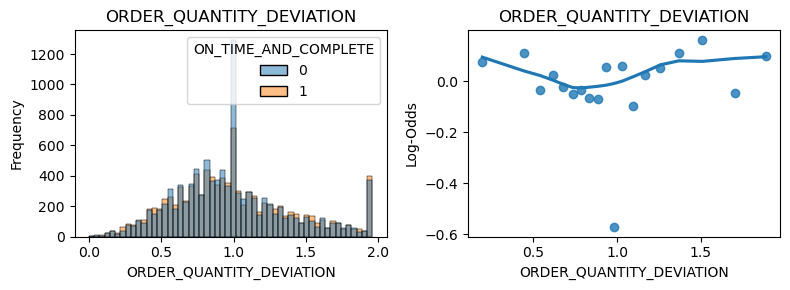

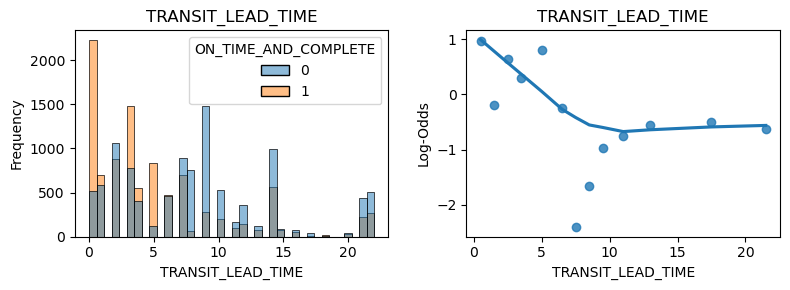

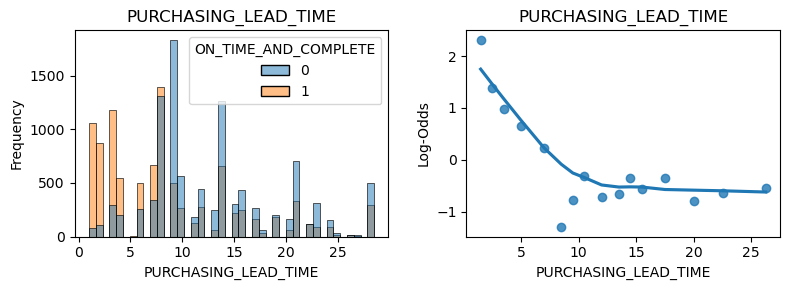

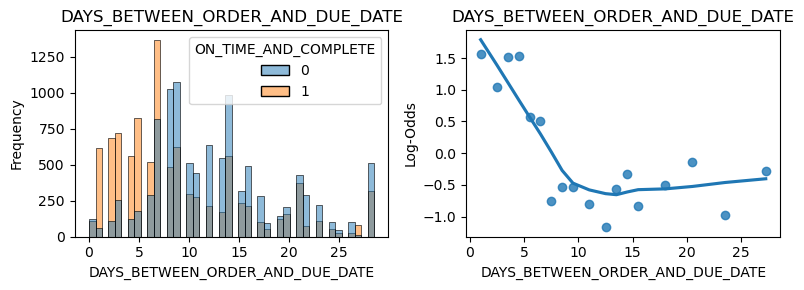

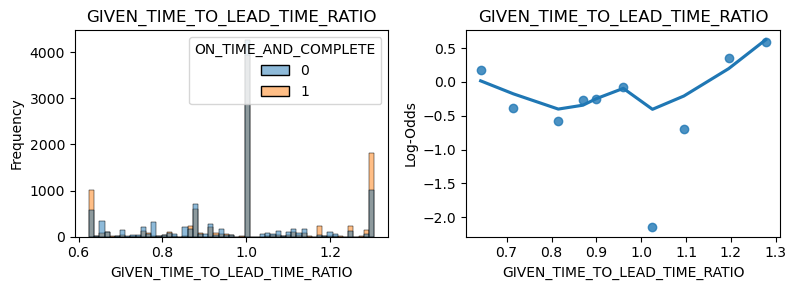

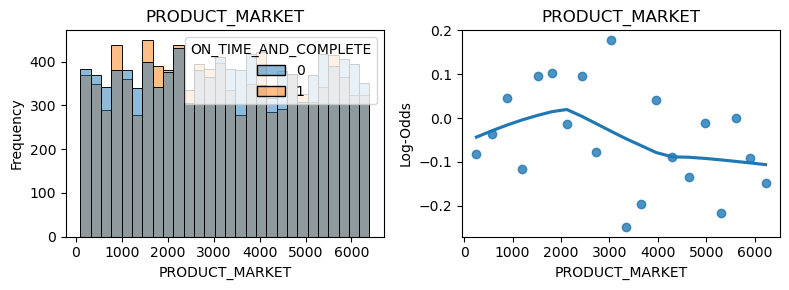

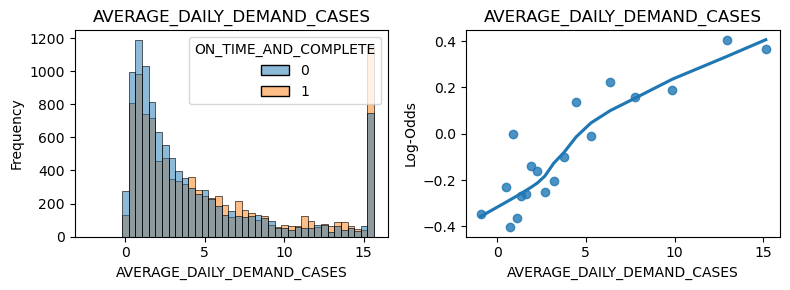

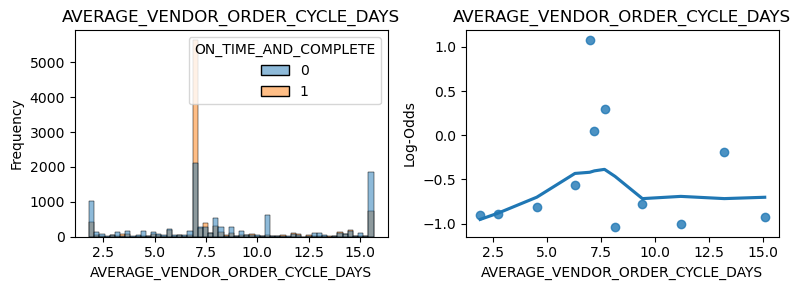

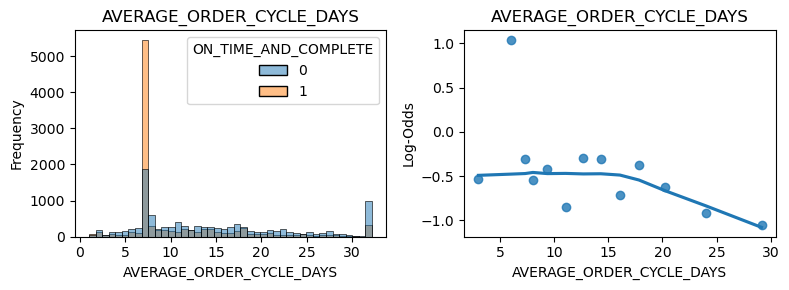

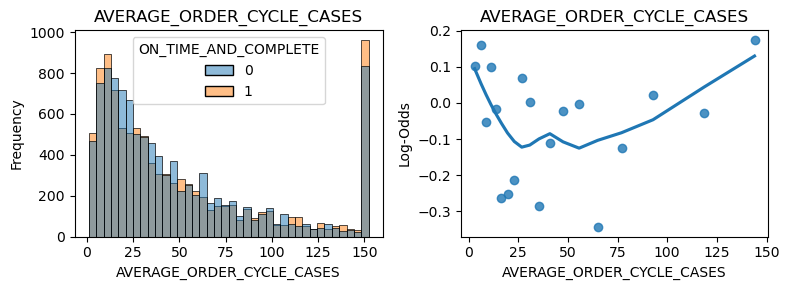

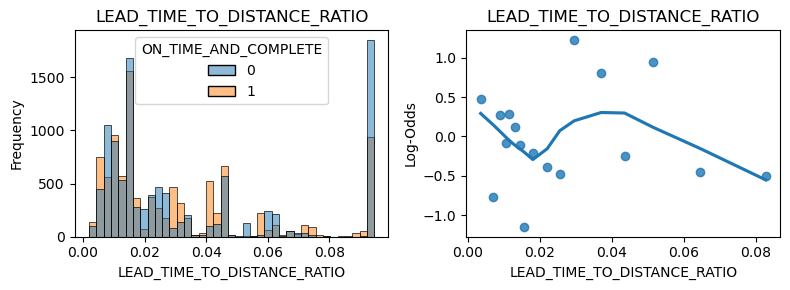

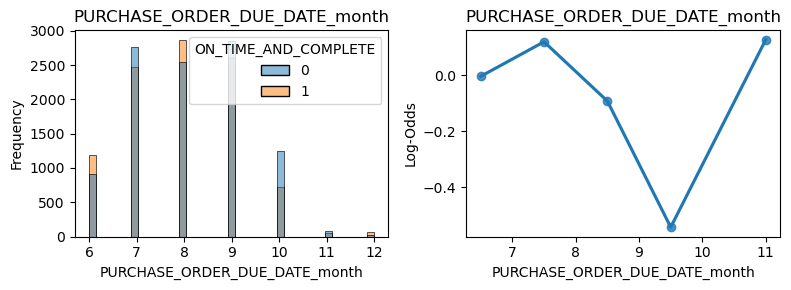

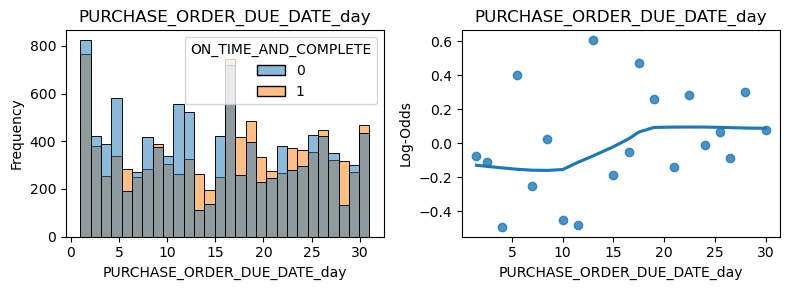

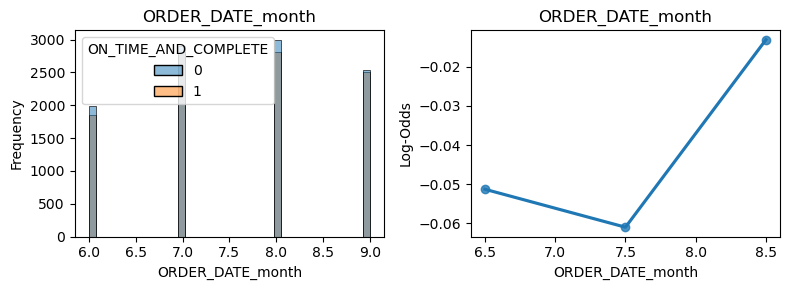

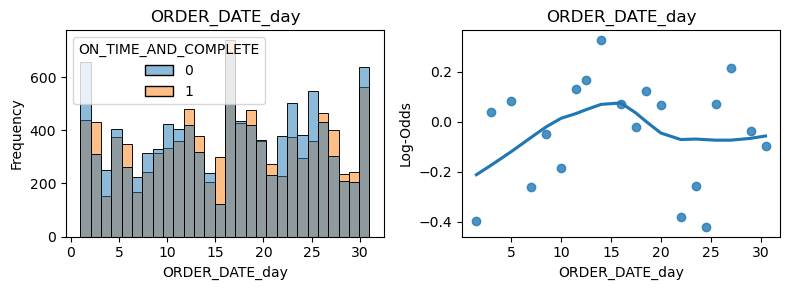

In [6]:
### ------------------ DATA VISUALIZATION -------------------

# Applying the outlier handler to the train data to mimic how it will be applied in the pipeline
outlier_handler_ex = OutlierHandler(columns=num_preds, strategy='clip')
train_outliers_handled = outlier_handler_ex.fit_transform(train[num_preds])
train_outliers_handled['ON_TIME_AND_COMPLETE'] = train['ON_TIME_AND_COMPLETE']

# Function to approximate the log odds
# Function to compute log odds
def compute_log_odds(df, predictor, response, bins=20):
    df['bin'] = pd.qcut(df[predictor], q=bins, duplicates='drop') # Binning the data to get a better approximation of the relationship
    grouped = df.groupby('bin')[response].agg(['mean'])
    
    # Compute log odds
    grouped['log_odds'] = np.log(grouped['mean'] / (1 - grouped['mean']))
    
    return grouped


# For each column, plotting the distribution and the log odds aproximated relationship
for col in num_preds:
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))

    # Histogram of predictor on train data
    sns.histplot(data = train_outliers_handled, x=col, ax=axes[0], hue='ON_TIME_AND_COMPLETE')
    axes[0].set_title(f'{col}')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Frequency')

    # Computing log odds for the column
    log_odds_data = compute_log_odds(train_outliers_handled, col, 'ON_TIME_AND_COMPLETE')

    # Scatterplot with trendline (regplot) of predictor on train predictor
    sns.regplot(x = log_odds_data.index.categories.mid, y = log_odds_data['log_odds'], ax=axes[1], scatter=True, lowess=True) # lowess=True allows for a non-linear trendline to be shown
    axes[1].set_title(f'{col}')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Log-Odds')    

    # Showing the plots
    plt.tight_layout()
    plt.show()



In [7]:
# Dropping variables that won't be useful
cols_to_drop = [
    'PRODUCT_NUMBER',
    'AVERAGE_VENDOR_ORDER_CYCLE_DAYS',
    'AVERAGE_ORDER_CYCLE_CASES',
    'SHIP_FROM_VENDOR',
    'ORDER_DATE_month',
    'PURCHASE_ORDER_DUE_DATE_month',
    'ORDER_DATE_day',
    'PURCHASE_ORDER_DUE_DATE_day',

]

train.drop(columns = cols_to_drop, inplace=True)
test_X.drop(columns = cols_to_drop, inplace=True)

In [8]:
### ------------------ TRANSFORMATIONS -------------------

# Log transformations
log_preds = [
    'AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET', 
    'TRANSIT_LEAD_TIME',
    'PURCHASING_LEAD_TIME', # INCREASES ACCURACY
    'DAYS_BETWEEN_ORDER_AND_DUE_DATE', # INCREASES ACCURACY
    
]

def log_transformation(X):
    X = np.where(X <= -1, 0.999, X) # making sure to not pass negative values to the logorithm
    return np.log1p(X)

for col in log_preds:
    train[col] = log_transformation(train[col])
    test_X[col] = log_transformation(test_X[col])

# Interaction Terms

#interaction_pairs = [
    #('AVERAGE_DAILY_DEMAND_CASES', 'AVERAGE_ORDER_CYCLE_DAYS'),
    #('ORDER_DAY_OF_WEEK', 'AVERAGE_DAILY_DEMAND_CASES'),
    #('COMPANY_VENDOR_NUMBER','PURCHASE_ORDER_DUE_DATE_day'),
    #('ORDER_DATE_month', 'ORDER_DATE_day'),
    #('PURCHASE_ORDER_DUE_DATE_month', 'PURCHASE_ORDER_DUE_DATE_day'),
#]

#for col1, col2 in interaction_pairs:
#    train[col1 + '_x_' + col2] = train[col1] * train[col2]
#    test_X[col1 + '_x_' + col2] = test_X[col1] * test_X[col2]

# removing original columns
#for col1, col2 in interaction_pairs:
#    train.drop(columns=[col1, col2], inplace=True)
#    test_X.drop(columns=[col1, col2], inplace=True)




# Redefining categorical columns based on the data viz above
# Making new categorical columns
train['AVERAGE_ORDER_CYCLE_DAYS_binned'] = pd.cut(train['AVERAGE_ORDER_CYCLE_DAYS'], bins=[-1,6,8,20])
test_X['AVERAGE_ORDER_CYCLE_DAYS_binned'] = pd.cut(test_X['AVERAGE_ORDER_CYCLE_DAYS'], bins=[-1,6,8,20])

# Redefining the categorical columns to include those we just created
cat_preds = cat_preds + [
    'AVERAGE_ORDER_CYCLE_DAYS_binned', 
]
train.drop(columns=['AVERAGE_ORDER_CYCLE_DAYS'], inplace=True)
test_X.drop(columns=['AVERAGE_ORDER_CYCLE_DAYS'], inplace=True)


# Redefining the numerical columns to include those we just created
num_preds = [col for col in train.columns if col not in cat_preds + ["ON_TIME_AND_COMPLETE"]]

In [9]:
### ------------------- PIPELINE -------------------

num_pipeline = Pipeline([
    ('outlier_handler', OutlierHandler(strategy='clip')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_preds),
    ('cat', cat_pipeline, cat_preds)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=5000, solver='lbfgs'))
])

In [10]:
### ------------------- FITTING THE MODEL (TRAIN-TEST SPLIT) -------------------

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns=['ON_TIME_AND_COMPLETE']), train['ON_TIME_AND_COMPLETE'], test_size=0.2, random_state=42)

# Fitting the model
model_split = pipeline.fit(X_train, y_train)
model_split



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('outlier_handler',
                                                                   OutlierHandler()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['DISTANCE_IN_MILES',
                                                   'AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET',
                                                   'ORDER_QUANTITY_DEVIATION',
                                                   'TRANSIT_LEAD_TIME',
                                                   'PURCHASING_LEAD_TIME',
                                                   'DAYS_BETWEEN_ORDER_AND_DUE_DATE',
                                                   'GIVEN_TIME_TO_LEAD_TIME_RATIO'...
                                                   'LEAD_TIME_TO_DISTANCE_RATIO']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['DIVISION_NUMBER',
                                                   'ORDER_DAY_OF_WEEK',
                                                   'PURCHASE_ORDER_TYPE',
                                                   'DIVISION_CODE',
                                                   'DUE_DATE_WEEKDAY',
                                                   'PRODUCT_CLASSIFICATION',
                                                   'COMPANY_VENDOR_NUMBER',
                                                   'PURCHASE_FROM_VENDOR',
                                                   'AVERAGE_ORDER_CYCLE_DAYS_binned'])])),
                ('model', LogisticRegression(max_iter=5000))])

In [11]:
# Finding both accuracies
train_accuracy = accuracy_score(y_train, model_split.predict(X_train))
test_accuracy = accuracy_score(y_test, model_split.predict(X_test))
print("Train accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)

Train accuracy: 0.7939987752602572
Test accuracy: 0.7913299044819986


/Users/hayden/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [12]:
## ------------------- FITTING THE MODEL (FULL DATASET) -------------------

# Fitting the model
model_full = pipeline.fit(train.drop(columns=['ON_TIME_AND_COMPLETE']), train['ON_TIME_AND_COMPLETE'])

# Finding both accuracies
train_accuracy = accuracy_score(train['ON_TIME_AND_COMPLETE'], model_full.predict(train.drop(columns=['ON_TIME_AND_COMPLETE'])))
print("Train accuracy:", train_accuracy)

Train accuracy: 0.7964532405819821


In [352]:
### ------------- MAKING & EXPORTING PREDICTIONS -------------

# making predicitons
predicted_classes = model_full.predict(test_X)


# Exporting for a kaggle submission - a csv file with two columns: ID and ON_TIME_AND_COMPLETE
submission = pd.DataFrame({"ID": test_X['ID'], "ON_TIME_AND_COMPLETE": predicted_classes})
submission.to_csv("submission6.3.csv", index=False)

/Users/hayden/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [5, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
